In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch

# Check if GPU is available and set device to GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available -> use CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla V100-SXM2-16GB


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define paths for datasets
# evaluation_dataset_path = '/content/drive/My Drive/IR Classification/Dataset/evaluation_dataset.csv'
# initial_labeling_dataset_path = '/content/drive/My Drive/IR Classification/Dataset/initial_labeling_dataset.csv'
# semi_supervised_dataset_path = '/content/drive/My Drive/IR Classification/Dataset/semi_supervised_dataset.csv'
evaluation_dataset_path = './evaluation_dataset.csv'
initial_labeling_dataset_path = './initial_labeling_dataset.csv'
semi_supervised_dataset_path = './semi_supervised_dataset.csv'

# Load datasets
df_evaluation_subjective = pd.read_csv(evaluation_dataset_path)
df_initial_labeling_subjective = pd.read_csv(initial_labeling_dataset_path)
df_semi_supervised_subjective = pd.read_csv(semi_supervised_dataset_path)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch.optim import AdamW
from tqdm.notebook import tqdm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def train_model(model, dataloader, optimizer):
    """Train the model on training data."""
    model.train()  # Set model to training mode
    total_train_loss = 0

    # Iterate over batches
    for batch in tqdm(dataloader, desc="Training"):
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(**inputs)  # Forward pass
        loss = outputs[0]  # Get loss
        total_train_loss += loss.item()  # Accumulate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    # Compute average loss
    avg_train_loss = total_train_loss / len(dataloader)
    print(f"Average training loss: {avg_train_loss}")

def evaluate_model(model, dataloader):
    """Evaluate the model's performance on a dataset."""
    model.eval()  # Set model to evaluation mode
    total_eval_accuracy = 0
    all_preds = []
    all_labels = []

    # Iterate over batches
    for batch in tqdm(dataloader, desc="Evaluating"):
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

        with torch.no_grad():  # Disable gradient calculation
            outputs = model(**inputs)

        logits = outputs[1]
        preds = torch.argmax(logits, dim=1).flatten()  # Get predictions

        # Accumulate predictions and labels
        all_preds.extend(preds.tolist())
        all_labels.extend(inputs['labels'].flatten().tolist())

        # Calculate accuracy
        total_eval_accuracy += torch.sum(preds == inputs['labels'].flatten()).item()

    # Compute average accuracy
    avg_accuracy = total_eval_accuracy / len(dataloader.dataset)
    print(f"Accuracy: {avg_accuracy}")

    # Generate confusion matrix and classification report
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
    report = classification_report(all_labels, all_preds, target_names=['Negative', 'Neutral', 'Positive'], digits=4)
    print("\nClassification Report:")
    print(report)
    return cm, report

def prepare_dataloader(df, tokenizer, batch_size=32, max_length=256):
    """Creates a DataLoader for model training or evaluation."""
    # Fill missing text entries
    df['post_comment_processed'].fillna("", inplace=True)

    # Map sentiment labels to integers
    sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
    labels = df['sentiment'].map(sentiment_mapping).values
    labels = torch.tensor(labels).long()

    # Tokenize text
    encoding = tokenizer(df['post_comment_processed'].tolist(),
                         add_special_tokens=True,
                         max_length=max_length,
                         padding='max_length',
                         truncation=True,
                         return_tensors='pt')

    # Create TensorDataset and DataLoader
    dataset = TensorDataset(encoding['input_ids'], encoding['attention_mask'], labels)
    dataloader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=batch_size)

    return dataloader

def generate_pseudo_labels(model, data_loader, tokenizer, device, confidence_threshold=0.9):
    """Generates pseudo-labels for unlabeled data using the model."""
    model.eval()  # Set model to evaluation mode
    pseudo_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for batch in tqdm(data_loader, desc="Pseudo-labeling"):
            # Move batch to device
            input_ids, attention_mask = batch[:2]
            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

            # Model prediction
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            max_probs, preds = torch.max(probs, dim=1)

            # Select high-confidence predictions
            high_confidence_indices = max_probs > confidence_threshold
            high_confidence_texts = tokenizer.batch_decode(input_ids[high_confidence_indices], skip_special_tokens=True)
            high_confidence_labels = preds[high_confidence_indices].tolist()

            pseudo_labels.extend(zip(high_confidence_texts, high_confidence_labels))

    # Create DataFrame for pseudo-labeled data
    df_pseudo_labels = pd.DataFrame(pseudo_labels, columns=['post_comment_processed', 'sentiment'])
    df_pseudo_labels['sentiment'] = df_pseudo_labels['sentiment'].map({0: 'negative', 1: 'neutral', 2: 'positive'})

    return df_pseudo_labels

def update_semi_supervised_dataset(original_df, pseudo_labeled_df):
    """Updates the dataset by removing pseudo-labeled examples."""
    return original_df[~original_df['post_comment_processed'].isin(pseudo_labeled_df['post_comment_processed'])]


In [ ]:
# Initialize the BERT model and tokenizer for sequence classification
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,  # Three sentiment classes: negative, neutral, positive
    output_attentions=False,
    output_hidden_states=False,
).to(device)


# Set up the optimizer with recommended settings
optimizer = AdamW(model_bert.parameters(), lr=5e-5, eps=1e-8)
epochs = 4  # Define the total number of training epochs

# Split initial labeling data for training and validation
df_train_initial, df_validation_initial = train_test_split(df_initial_labeling_subjective, test_size=0.2, random_state=42)

# Prepare dataloaders for initial training, validation, and evaluation
train_dataloader = prepare_dataloader(df_train_initial, tokenizer_bert, batch_size=16, max_length=128)
validation_dataloader = prepare_dataloader(df_validation_initial, tokenizer_bert, batch_size=16, max_length=128)
evaluation_dataloader = prepare_dataloader(df_evaluation_subjective, tokenizer_bert, batch_size=16, max_length=128)

# Initialize dataset for semi-supervised learning iterations
df_semi_supervised_current = df_semi_supervised_subjective.copy()

# Define dynamic threshold for pseudo-label generation
threshold = 0.95  # Initial threshold for pseudo-labeling
# threshold_updates = {5: 0.9, 9: 0.85, 12: 0.82}  # Update thresholds based on iteration
threshold_updates = {6: 0.9, 10: 0.88, 12: 0.85}

# Semi-supervised learning loop
ssl_iterations = 14  # Set the total number of iterations for semi-supervised learning
for iteration in range(ssl_iterations):
    print(f"Iteration {iteration + 1}/{ssl_iterations}")

    # Adjust the threshold dynamically per iteration
    if iteration in threshold_updates:
        threshold = threshold_updates[iteration]

    # Prepare DataLoader for semi-supervised learning with the current dataset
    semi_supervised_data_loader = prepare_dataloader(df_semi_supervised_current, tokenizer_bert, batch_size=16, max_length=128)

    # Generate pseudo-labels and combine with the initial training data
    if iteration > 0:
        df_pseudo_labels = generate_pseudo_labels(model_bert, semi_supervised_data_loader, tokenizer_bert, device, threshold)
        combined_df = pd.concat([df_train_initial, df_pseudo_labels])  # Combine for retraining
        train_dataloader = prepare_dataloader(combined_df, tokenizer_bert, batch_size=16, max_length=128)

    # Recalculate the total steps for the learning rate scheduler
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Train and evaluate the model with the updated dataloader
    train_model(model_bert, train_dataloader, optimizer)
    evaluate_model(model_bert, validation_dataloader)

    # Update the dataset for the next iteration
    if iteration > 0:
        df_semi_supervised_current = update_semi_supervised_dataset(df_semi_supervised_current, df_pseudo_labels)

    # Print the remaining number of unlabeled datasets
    print(f"Remaining unlabeled data after iteration {iteration + 1}: {len(df_semi_supervised_current)}")

print("Semi-Supervised Learning completed.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Iteration 1/14


Training:   0%|          | 0/214 [00:00<?, ?it/s]

Average training loss: 0.746334858238697


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.7371495327102804

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6024    0.4630    0.5236       216
     Neutral     0.7231    0.7176    0.7203       131
    Positive     0.7804    0.8585    0.8176       509

    accuracy                         0.7371       856
   macro avg     0.7019    0.6797    0.6872       856
weighted avg     0.7267    0.7371    0.7285       856

Remaining unlabeled data after iteration 1: 9978
Iteration 2/14


Pseudo-labeling:   0%|          | 0/624 [00:00<?, ?it/s]

Training:   0%|          | 0/216 [00:00<?, ?it/s]

Average training loss: 0.47578641941288


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.7850467289719626

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6105    0.8056    0.6946       216
     Neutral     0.7671    0.8550    0.8087       131
    Positive     0.9082    0.7583    0.8266       509

    accuracy                         0.7850       856
   macro avg     0.7620    0.8063    0.7766       856
weighted avg     0.8115    0.7850    0.7905       856

Remaining unlabeled data after iteration 2: 9951
Iteration 3/14


<ipython-input-4-3b8bf05e255a>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/622 [00:00<?, ?it/s]

Training:   0%|          | 0/383 [00:00<?, ?it/s]

Average training loss: 0.18308648894426677


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8177570093457944

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7727    0.6296    0.6939       216
     Neutral     0.8240    0.7863    0.8047       131
    Positive     0.8306    0.9057    0.8665       509

    accuracy                         0.8178       856
   macro avg     0.8091    0.7739    0.7884       856
weighted avg     0.8150    0.8178    0.8135       856

Remaining unlabeled data after iteration 3: 7528
Iteration 4/14


<ipython-input-4-3b8bf05e255a>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/471 [00:00<?, ?it/s]

Training:   0%|          | 0/423 [00:00<?, ?it/s]

Average training loss: 0.13180212533414082


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8212616822429907

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6933    0.7639    0.7269       216
     Neutral     0.8443    0.7863    0.8142       131
    Positive     0.8770    0.8546    0.8657       509

    accuracy                         0.8213       856
   macro avg     0.8049    0.8016    0.8023       856
weighted avg     0.8256    0.8213    0.8228       856

Remaining unlabeled data after iteration 4: 4652
Iteration 5/14


<ipython-input-4-3b8bf05e255a>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/291 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Average training loss: 0.14565802856643026


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8200934579439252

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7609    0.6481    0.7000       216
     Neutral     0.8547    0.7634    0.8065       131
    Positive     0.8324    0.9077    0.8684       509

    accuracy                         0.8201       856
   macro avg     0.8160    0.7731    0.7916       856
weighted avg     0.8178    0.8201    0.8164       856

Remaining unlabeled data after iteration 5: 3613
Iteration 6/14


<ipython-input-4-3b8bf05e255a>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/226 [00:00<?, ?it/s]

Training:   0%|          | 0/340 [00:00<?, ?it/s]

Average training loss: 0.12210084649337018


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8084112149532711

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6737    0.7361    0.7035       216
     Neutral     0.9091    0.6107    0.7306       131
    Positive     0.8515    0.8900    0.8703       509

    accuracy                         0.8084       856
   macro avg     0.8114    0.7456    0.7682       856
weighted avg     0.8155    0.8084    0.8069       856

Remaining unlabeled data after iteration 6: 2272
Iteration 7/14


<ipython-input-4-3b8bf05e255a>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/142 [00:00<?, ?it/s]

Training:   0%|          | 0/310 [00:00<?, ?it/s]

Average training loss: 0.13373805135563616


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8200934579439252

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7177    0.6944    0.7059       216
     Neutral     0.8785    0.7176    0.7899       131
    Positive     0.8481    0.8998    0.8732       509

    accuracy                         0.8201       856
   macro avg     0.8148    0.7706    0.7897       856
weighted avg     0.8199    0.8201    0.8182       856

Remaining unlabeled data after iteration 7: 1466
Iteration 8/14


<ipython-input-4-3b8bf05e255a>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/92 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Average training loss: 0.05907442762745768


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.7978971962616822

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6237    0.8287    0.7117       216
     Neutral     0.8509    0.7405    0.7918       131
    Positive     0.8945    0.7996    0.8444       509

    accuracy                         0.7979       856
   macro avg     0.7897    0.7896    0.7827       856
weighted avg     0.8195    0.7979    0.8029       856

Remaining unlabeled data after iteration 8: 1352
Iteration 9/14


<ipython-input-4-3b8bf05e255a>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/283 [00:00<?, ?it/s]

Average training loss: 0.10087913122643509


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.7955607476635514

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6122    0.8333    0.7059       216
     Neutral     0.8913    0.6260    0.7354       131
    Positive     0.8915    0.8232    0.8560       509

    accuracy                         0.7956       856
   macro avg     0.7983    0.7608    0.7658       856
weighted avg     0.8210    0.7956    0.7997       856

Remaining unlabeled data after iteration 9: 982
Iteration 10/14


<ipython-input-4-3b8bf05e255a>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/62 [00:00<?, ?it/s]

Training:   0%|          | 0/264 [00:00<?, ?it/s]

Average training loss: 0.04667504235906315


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8119158878504673

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6721    0.7593    0.7130       216
     Neutral     0.8421    0.7328    0.7837       131
    Positive     0.8735    0.8546    0.8640       509

    accuracy                         0.8119       856
   macro avg     0.7959    0.7822    0.7869       856
weighted avg     0.8179    0.8119    0.8136       856

Remaining unlabeled data after iteration 10: 912
Iteration 11/14


<ipython-input-4-3b8bf05e255a>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/57 [00:00<?, ?it/s]

Training:   0%|          | 0/263 [00:00<?, ?it/s]

Average training loss: 0.027435472787945697


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.794392523364486

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6138    0.8241    0.7036       216
     Neutral     0.8750    0.6947    0.7745       131
    Positive     0.8896    0.8075    0.8465       509

    accuracy                         0.7944       856
   macro avg     0.7928    0.7754    0.7749       856
weighted avg     0.8178    0.7944    0.7994       856

Remaining unlabeled data after iteration 11: 885
Iteration 12/14


<ipython-input-4-3b8bf05e255a>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/56 [00:00<?, ?it/s]

Training:   0%|          | 0/264 [00:00<?, ?it/s]

Average training loss: 0.04725262717626968


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8177570093457944

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6833    0.7593    0.7193       216
     Neutral     0.8571    0.7328    0.7901       131
    Positive     0.8730    0.8644    0.8687       509

    accuracy                         0.8178       856
   macro avg     0.8045    0.7855    0.7927       856
weighted avg     0.8227    0.8178    0.8190       856

Remaining unlabeled data after iteration 12: 842
Iteration 13/14


<ipython-input-4-3b8bf05e255a>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/53 [00:00<?, ?it/s]

Training:   0%|          | 0/265 [00:00<?, ?it/s]

Average training loss: 0.03954290184785419


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8212616822429907

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6757    0.8102    0.7368       216
     Neutral     0.8899    0.7405    0.8083       131
    Positive     0.8832    0.8468    0.8646       509

    accuracy                         0.8213       856
   macro avg     0.8163    0.7991    0.8033       856
weighted avg     0.8319    0.8213    0.8237       856

Remaining unlabeled data after iteration 13: 798
Iteration 14/14


<ipython-input-4-3b8bf05e255a>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/263 [00:00<?, ?it/s]

Average training loss: 0.026551761499012044


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8084112149532711

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7530    0.5787    0.6545       216
     Neutral     0.8932    0.7023    0.7863       131
    Positive     0.8092    0.9332    0.8668       509

    accuracy                         0.8084       856
   macro avg     0.8185    0.7381    0.7692       856
weighted avg     0.8079    0.8084    0.8009       856

Remaining unlabeled data after iteration 14: 787
Semi-Supervised Learning completed.



Final Evaluation on Test Set:


Evaluating:   0%|          | 0/99 [00:00<?, ?it/s]

Accuracy: 0.797979797979798

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7439    0.5966    0.6621       409
     Neutral     0.8367    0.6457    0.7289       254
    Positive     0.8075    0.9294    0.8642       921

    accuracy                         0.7980      1584
   macro avg     0.7961    0.7239    0.7517      1584
weighted avg     0.7958    0.7980    0.7903      1584



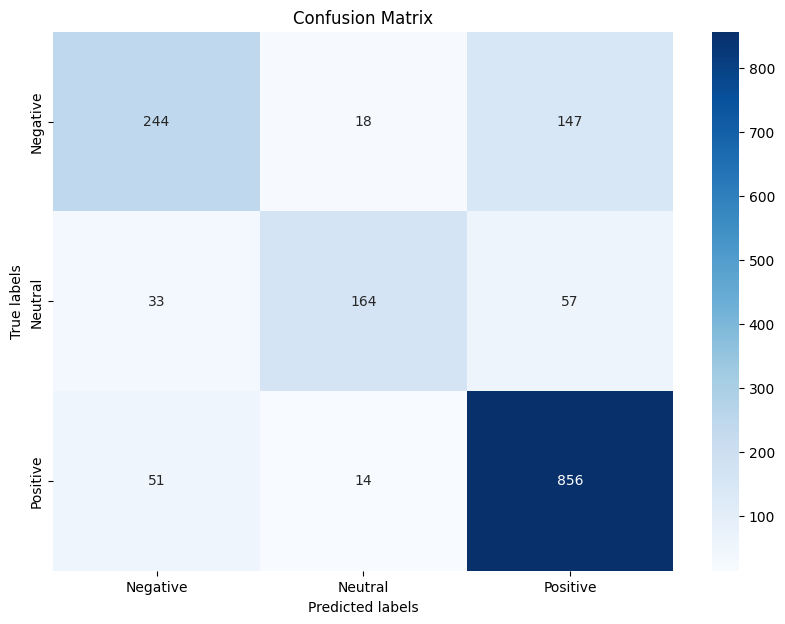

In [ ]:
# Conduct final evaluation on the unseen test dataset
print("\nFinal Evaluation on Test Set:")
cm, report = evaluate_model(model_bert, evaluation_dataloader)

# Define class names for the confusion matrix
class_names = ['Negative', 'Neutral', 'Positive']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')  # Label for the x-axis
plt.ylabel('True labels')  # Label for the y-axis
plt.title('Confusion Matrix')  # Title of the plot
plt.show()  # Display the plot

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Convert categorical labels to integers
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(df_evaluation_subjective['sentiment'].values)

# Generate random predictions
num_classes = 3  # Negative, Neutral, Positive
random_preds = np.random.randint(0, num_classes, size=len(true_labels_encoded))

# Calculate random accuracy
random_accuracy = accuracy_score(true_labels_encoded, random_preds)
print(f"Random Accuracy: {random_accuracy:.4f}")

Random Accuracy: 0.3580


In [ ]:
# For Prof -> since we already saved the model weights, dont have to resave if you are testing this code 

# Save the model's state dictionary
# bert_model_save_path = "/content/drive/My Drive/IR Classification/Models/bert_model_state.bin"
# torch.save(model_bert.state_dict(), bert_model_save_path)